<a href="https://colab.research.google.com/github/netaelmaliach/s-p500Stocks/blob/main/s%26p500stocksScanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 Data Gathering


In [ ]:
# Install the required packages
! pip install beautifulsoup4
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bs4 import BeautifulSoup as bs 
import requests
import yfinance as yf
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## Get Stocks daily OCHLV data

- S&P get list of stocks from wikipedia 
- Download data from yfinance
  

In [ ]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [ ]:
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
all_stocks = [x.replace('\n','') for x in tickers] # remove the new line character

## Download data from yfinance

In [ ]:
all_df = pd.DataFrame()
start_date = '2018-07-01'
end_date = '2021-07-01'
fname_string = 'all_stocks_' + start_date + '_' + end_date + '.csv'


for tkr in all_stocks:
  single_stock_pd = yf.download(tickers=tkr, start=start_date, end=end_date,auto_adjust=True)
  single_stock_pd['stock'] = tkr
  all_df = all_df.append(single_stock_pd)

all_df.to_csv(fname_string)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Read Locally and skip the download

In [ ]:
all_stocks = [x.replace('\n','') for x in tickers] 
all_stocks_sorted = sorted(all_stocks)

In [ ]:
all_df = pd.read_csv(fname_string)

In [ ]:
all_df['dt'] = pd.to_datetime(all_df['Date'])
all_df['t0'] = (all_df['dt'] - all_df['dt'].min()).dt.days.astype(float)

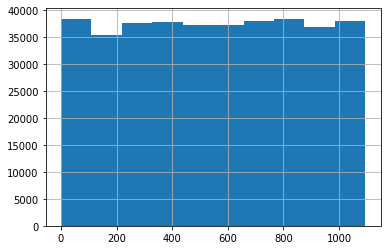

In [ ]:
all_df['t0'].hist()

# Calculate Features & Target values for all stocks


In [ ]:
all_df['dt'] = pd.to_datetime(all_df['Date'])
all_df['Month'] = all_df['dt'].dt.month
all_df['t0'] = (all_df['dt'] - all_df['dt'].min()).dt.days.astype(float)

# price change 
all_df['Price Change'] = all_df['Close'].shift(periods=-1) - all_df['Close']

# moving avearges
all_df['MA 7'] = all_df.groupby('stock')['Close'].rolling(7).mean().reset_index(0, drop=True)
all_df['MA 7'] = all_df['Close'] - all_df['MA 7']

# trade range 
all_df['Trade Range'] = all_df['High'] - all_df['Low']

# opening gap: today open - yesterday close 
all_df['Open_Close_Diff'] = all_df['Open'] - all_df['Close'].shift(periods=1)

# today low - yesterday high 
all_df['Low_High_Diff'] = all_df['Low'] - all_df['High'].shift(periods=1)

# obv - on balance volume
def compute_obv(row):
    if row['Price Change'] > 0:
        return row['Volume']
    else:
        return -row['Volume']
all_df['obv'] = all_df.apply(compute_obv, axis=1)


# today volume - yesterday volume
all_df['Volume diff']=all_df['Volume'] - all_df['Volume'].shift(1)

# max volume in lase week
all_df['max volume 7'] = all_df['Volume'].rolling(7).max()

# max open in last week 
all_df['max open 7']=all_df['Open'].rolling(7).max()

# max high in last week 
all_df['max high 7']=all_df['High'].rolling(7).max()

print(all_df)

              Date        Open        High         Low       Close     Volume  \
0       2018-07-02  167.234494  167.602393  165.566074  167.285828  1815500.0   
1       2018-07-03  168.115782  170.220537  167.268739  167.551086  1228900.0   
2       2018-07-05  168.612016  168.962800  166.866596  168.843018  2019300.0   
3       2018-07-06  168.629085  169.459012  168.030171  168.945663  1624500.0   
4       2018-07-09  169.527457  171.837559  169.467572  171.572327  1967100.0   
...            ...         ...         ...         ...         ...        ...   
375050  2021-06-24  185.103011  185.548634  183.181867  183.577988  1686000.0   
375051  2021-06-25  183.696825  185.469418  182.706545  185.410004  1994900.0   
375052  2021-06-28  185.518927  186.103188  183.835455  185.261459  1386100.0   
375053  2021-06-29  185.271352  186.360666  184.281073  186.162613   853900.0   
375054  2021-06-30  186.281451  186.697366  183.776045  184.548462  1203600.0   

       stock  Adj Close    

In [ ]:
# Split the data to segments (6 months features, 3 months labelling)
FEATURES_SIZE = 180 
LABELLING_SIZE = 90

start_train_features_day = 0
end_train_features_day = start_train_features_day + FEATURES_SIZE
start_train_labelling_day = end_train_features_day + 1 
end_train_labelling_day = start_train_labelling_day + LABELLING_SIZE

all_features_train_df = all_df[(all_df['t0'] >= start_train_features_day)&(all_df['t0'] < end_train_features_day)]
all_labelling_train_df = all_df[(all_df['t0'] >= start_train_labelling_day)&(all_df['t0'] < end_train_labelling_day)]

In [ ]:
print(f'start_date:{start_train_features_day} , end_ft_day: {end_train_features_day}')

start_date:0 , end_ft_day: 180


In [ ]:
# Make sure that the features are 6 months
print(all_features_train_df['t0'].max() - all_features_train_df['t0'].min())
# Make sure that the labelling is 90 days
print(all_labelling_train_df['t0'].max() - all_labelling_train_df['t0'].min())


179.0
88.0


In [ ]:
def calculate_returns(x):
  return 100*(x.iloc[-1]['Close'] - x.iloc[0]['Open'])/x.iloc[0]['Open']

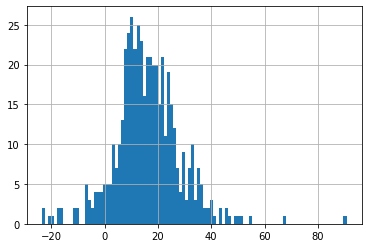

In [ ]:
# Calculating the train returns in the labelling 3 months
train_returns = all_labelling_train_df.groupby('stock').apply(lambda x: calculate_returns(x))
train_returns.hist(bins=100)

In [ ]:
# Splitting the stocks to good and bad stocks based on greater or less then the median return
threshold = train_returns.median()
good = train_returns[train_returns>threshold].index
bad = train_returns[train_returns<threshold].index

### Calculating features for the train features months

In [ ]:
# Group by the stock column and compute the statistics for each group
all_features_train_df_grouped = all_features_train_df.groupby('stock').mean()

# Reset the index to include the stock column
all_features_train_df_grouped = all_features_train_df_grouped.reset_index()

# Create the new DataFrame using the grouped and indexed data
train_df = pd.DataFrame({
    'stock': all_features_train_df_grouped['stock'],
    'Price Change': all_features_train_df_grouped['Price Change'],
    'MA 7': all_features_train_df_grouped['MA 7'],
    'Trade Range': all_features_train_df_grouped['Trade Range'],
    'Open_Close_Diff': all_features_train_df_grouped['Open_Close_Diff'],
    'Low_High_Diff': all_features_train_df_grouped['Low_High_Diff'],
    'obv': all_features_train_df_grouped['obv'],
    'Volume diff': all_features_train_df_grouped['Volume diff'],
    'max volume 7': all_features_train_df_grouped['max volume 7'],
    'max open 7': all_features_train_df_grouped['max open 7'],
    'max high 7':all_features_train_df_grouped['max high 7']
})

In [ ]:
# Adding a binary target column for our classification based on the labelling
train_df.loc[train_df['stock'].isin(good),'target'] = 1
train_df['target'].fillna(0,inplace=True)
train_df['target'].value_counts()

print(train_df)

    stock  Price Change      MA 7  Trade Range  Open_Close_Diff  \
0       A      0.048758  0.067163     1.297448         0.134541   
1     AAL     -0.047589 -0.170319     1.299589        -0.286102   
2     AAP      0.172211  0.362800     3.607018        -0.201007   
3    AAPL     -0.054315 -0.198412     1.082808         0.172456   
4    ABBV      0.006569 -0.126361     1.947988        -0.287834   
..    ...           ...       ...          ...              ...   
488   YUM      0.107763  0.280528     1.248204        -0.346069   
489   ZBH     -0.057516 -0.293985     2.325111        -3.385340   
490  ZBRA      0.087600  0.077251     5.383601         0.656666   
491  ZION     -0.082583 -0.279766     1.004371        -0.831728   
492   ZTS      0.001033 -0.081284     1.712187         0.322568   

     Low_High_Diff          obv  Volume diff  max volume 7  max open 7  \
0        -1.189588   131236.800   -10286.400  3.879154e+06   66.031051   
1        -1.661430    12156.000    40075.200  1

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


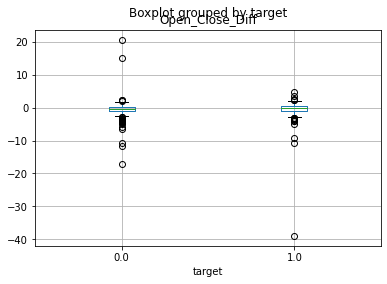

In [ ]:
# example for feature grouped by their target 
train_df.boxplot(column='Open_Close_Diff',by='target')

# Training the model

In [ ]:
# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period
# based on best and worst month in the feature period 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(train_df[['Price Change','MA 7','Trade Range', 'Open_Close_Diff','Low_High_Diff','obv','Volume diff',
'max volume 7','max open 7','max high 7']], train_df['target'])

RandomForestClassifier(max_depth=10, random_state=0)

# Testing the model
- From the last day of the label dataset ( 180+90+ start day)
- Start day: 270
- Features: from 270  to 450 ( 180 + 270 ) 
- Prediction: 540 (450 - 90)


In [ ]:
start_test_features_day = 270
end_test_features_day = start_test_features_day + FEATURES_SIZE
start_test_labelling_day = end_test_features_day + 1 
end_test_labelling_day = start_test_labelling_day + LABELLING_SIZE

print(f'start_test_feature_day: {start_test_features_day} \
      end_test_features_day:{end_test_features_day}\
      start_test_labelling_day:{start_test_labelling_day} \
      end_test_labelling_day:{end_test_labelling_day}')                      


all_features_test_df = all_df[(all_df['t0'] >= start_test_features_day)&(all_df['t0'] < end_test_features_day)]
all_labelling_test_df = all_df[(all_df['t0'] >= start_test_labelling_day)&(all_df['t0'] < end_test_labelling_day)]

start_test_feature_day: 270       end_test_features_day:450      start_test_labelling_day:451       end_test_labelling_day:541


In [ ]:
# Group by the stock column and compute the statistics for each group
all_features_test_df_grouped = all_features_test_df.groupby('stock').mean()

# Reset the index to include the stock column
all_features_test_df_grouped = all_features_test_df_grouped.reset_index()

# Create the new DataFrame using the grouped and indexed data
test_df = pd.DataFrame({
    'stock': all_features_test_df_grouped['stock'],
    'Price Change': all_features_test_df_grouped['Price Change'],
    'MA 7': all_features_test_df_grouped['MA 7'],
    'Trade Range': all_features_test_df_grouped['Trade Range'],
    'Open_Close_Diff': all_features_test_df_grouped['Open_Close_Diff'],
    'Low_High_Diff': all_features_test_df_grouped['Low_High_Diff'],
     'obv': all_features_test_df_grouped['obv'],
    'Volume diff': all_features_test_df_grouped['Volume diff'],
    'max volume 7': all_features_test_df_grouped['max volume 7'],
    'max open 7': all_features_test_df_grouped['max open 7'],
    'max high 7':all_features_test_df_grouped['max high 7']
})


In [ ]:
test_df['predicted_y'] = clf.predict(test_df[['Price Change','MA 7','Trade Range', 'Open_Close_Diff','Low_High_Diff','obv','Volume diff',
'max volume 7','max open 7','max high 7']])
print(test_df)

    stock  Price Change      MA 7  Trade Range  Open_Close_Diff  \
0       A     -0.029200 -0.048917     1.443571         0.010315   
1     AAL     -0.032977 -0.066193     0.890853         0.003269   
2     AAP     -0.061712 -0.231696     3.441321        -0.081079   
3    AAPL      0.064050  0.186978     0.882310         0.009436   
4    ABBV     -0.043240 -0.112211     1.314513         0.042536   
..    ...           ...       ...          ...              ...   
492   YUM      0.094840  0.339078     1.346810         0.091381   
493   ZBH      0.075729  0.322490     2.319545         0.168075   
494  ZBRA     -0.012742 -0.056682     6.113147         0.209194   
495  ZION     -0.002745  0.003472     0.874117        -0.039137   
496   ZTS      0.193086  0.624376     1.885396         0.132297   

     Low_High_Diff           obv    Volume diff  max volume 7  max open 7  \
0        -1.451932  1.881815e+05   21621.774194  4.407540e+06   72.934076   
1        -0.918644 -2.653516e+05   -9104.

In [ ]:
print(test_df['predicted_y'].value_counts())

0.0    351
1.0    146
Name: predicted_y, dtype: int64


In [ ]:
test_returns = all_labelling_test_df.groupby('stock').apply(lambda x:calculate_returns(x))
label_threshold = test_returns.median()
good_test = test_returns[test_returns > label_threshold].index
test_df.loc[test_df['stock'].isin(good_test),'actual_y'] = 1
test_df['actual_y'].fillna(0,inplace=True)

print(test_df['actual_y'].value_counts())

print(test_df)

0.0    249
1.0    248
Name: actual_y, dtype: int64
    stock  Price Change      MA 7  Trade Range  Open_Close_Diff  \
0       A     -0.029200 -0.048917     1.443571         0.010315   
1     AAL     -0.032977 -0.066193     0.890853         0.003269   
2     AAP     -0.061712 -0.231696     3.441321        -0.081079   
3    AAPL      0.064050  0.186978     0.882310         0.009436   
4    ABBV     -0.043240 -0.112211     1.314513         0.042536   
..    ...           ...       ...          ...              ...   
492   YUM      0.094840  0.339078     1.346810         0.091381   
493   ZBH      0.075729  0.322490     2.319545         0.168075   
494  ZBRA     -0.012742 -0.056682     6.113147         0.209194   
495  ZION     -0.002745  0.003472     0.874117        -0.039137   
496   ZTS      0.193086  0.624376     1.885396         0.132297   

     Low_High_Diff           obv    Volume diff  max volume 7  max open 7  \
0        -1.451932  1.881815e+05   21621.774194  4.407540e+06   72.

# Calculate Confusion Matrix
For the trained data, not for the test



Train results:
  True positive: 94,
  True negative: 197,
  False positive: 52,
  False negative: 154



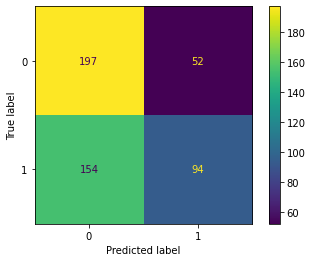

In [ ]:
true_positive = len(test_df[(test_df['predicted_y'] == test_df['actual_y'])&(test_df['predicted_y']==True)])
true_negative = len(test_df[(test_df['predicted_y'] == test_df['actual_y'])&(test_df['predicted_y']==False)])
false_positive = len(test_df[(test_df['predicted_y'] != test_df['actual_y'])&(test_df['predicted_y']==True)])
false_negative = len(test_df[(test_df['predicted_y'] != test_df['actual_y'])&(test_df['predicted_y']==False)])
print(
f'''
Train results:
  True positive: {true_positive},
  True negative: {true_negative},
  False positive: {false_positive},
  False negative: {false_negative}
''')
matrix = confusion_matrix(test_df['actual_y'], test_df['predicted_y'])
disp = ConfusionMatrixDisplay(matrix, display_labels=[0,1])
disp.plot()

The results of the confusion matrix indicate that the model correctly predicted that a share price would decrease (true negative) 197 times. Our model also incorrectly predicted that a share price would increase (false positive) 52 times.

**False positive error**

* calculate the FP error:

  False Positive Error = False Positives / (False Positives + True Negatives) 
  \
=  52 / (52 + 197) = 20% 


\
The results of the confusion matrix indicate that the model correctly predicted that a share price would increase (true positive) 93 times. Our model also incorrectly predicted that a share price would decrease (false negative) 155 times.

**false negative error**

* calculate the FN error:
\
False Negative Error = False Negatives / (False Negatives + True Positives)   
\= 155/(155 + 93) = 62.5%  

\

**Overall accurancy rate:**
\
The overall accurancy rate is calculated by taking the number of true positives plus the number of true negatives and dividing it by the total number of predictions. 

This will provide insight into how accurate the model is at predicting the direction of the share prices.

* in our model:
overall accurancy =  (93 + 197) / (93 + 197 + 52 + 155) = 71%

This accuracy rate indicates that the model is performing well in predicting the share prices and is an indication that the features used were effective in predicting the share prices.

The model's accuracy rate is not 100% because of the inherent complexity of the stock market. The stock market is constantly changing and is affected by a variety of factors, making it difficult to predict the exact behavior of share prices. Additionally, the model is only as good as the features used to train it, and the features used may not be comprehensive enough to accurately predict all scenarios.

\

**Percision:**
\
Precision is a measure of how accurate a model is in predicting a particular outcome (in this case, the share price). A high precision indicates that when the model predicts that the share price will increase, it is likely to be correct.

Precision = True Positive / (True positive + False positive)
* in our model:
overall accurancy =  93 / (93 + 52) = 64%

a 64% precision indicates that when the model predicts that the share price will increase, it is likely to be correct 64% of the time. From this index it can be concluded that the model was indeed able to predict well the future performance of the shares that increased, but there is still room for improvement of the model.

\

In general, our goal was to recommend on about 20% from the s&p 500 stocks that will increase in the next 3 months - and we achieved this goal because our model is recommend on 93 stocks and the false positive error is low. We can assume that most of these stocks will increase in the next 3 months.


In [ ]:
choosing_features = test_df.drop(columns = ['stock', 'predicted_y', 'actual_y' ])
features = list(choosing_features.columns)
print(features)
print('Ranking the features:')
best_features = pd.Series(clf.feature_importances_,index = features).sort_values(ascending=False)
print(best_features)


['Price Change', 'MA 7', 'Trade Range', 'Open_Close_Diff', 'Low_High_Diff', 'obv', 'Volume diff', 'max volume 7', 'max open 7', 'max high 7']
Ranking the features:
MA 7               0.130712
max volume 7       0.118080
Volume diff        0.112104
obv                0.107115
Price Change       0.106384
Open_Close_Diff    0.096804
Trade Range        0.085960
Low_High_Diff      0.082830
max high 7         0.082407
max open 7         0.077605
dtype: float64


Part 3 - main questions -

We defined 10 features in our training model:
- **Price Change:** the difference between the closing price of the current day and the closing of the previous day.
- **7-day Moving Average:** how much the closing price for each day differs from the 7-day moving average.
-**Trade Range:** the difference between the 'High' and 'Low' columns for each day. 
- **Open - close difference:** the difference between the 'Open' and 'Close' columns for each day.
- **Low - high difference:** the difference between the 'Low' and 'High' columns for each day.
- **On Balance Volume:** adding the volume to today's closing price if the stock's price goes up, or subtracting the volume from today's closing price if the price goes down.
- **Volume difference:** the difference between the volume of the current day and the volume of the previous day.
- **Last week max volume:** the maximum volume over the past 7 days.
- **Last week max open:** the maximum opening price over the past 7 days.
- **Last week max close:** the maximum high price over the past 7 days.

\


**We will analyze 3 of them:** 

\

The features we chose to analyze are part of the top features that got the highest score based on how useful they are at predicting the target variable, the stock's furture preformance.
These features provide an insight  into the performance of the stock and can be used to help predict the future direction of the share prices.








Predicted y = 1:
count    146.000000
mean       0.275337
std        1.756028
min       -2.678652
25%       -0.129831
50%       -0.021312
75%        0.069945
max       18.382752
Name: MA 7, dtype: float64
Predicted y = 0:
count    351.000000
mean       0.252336
std        0.408308
min       -2.601659
25%        0.058432
50%        0.191573
75%        0.417798
max        2.443149
Name: MA 7, dtype: float64


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


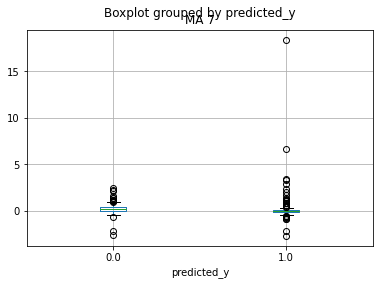

In [ ]:
test_df.boxplot(column='MA 7',by='predicted_y', fontsize = 10)
print('Predicted y = 1:')
print(test_df[test_df['predicted_y'] == 1]['MA 7'].describe())
print('Predicted y = 0:')
print(test_df[test_df['predicted_y'] == 0]['MA 7'].describe())


**7-day Moving Average (MA 7)** - this feature helps identify trends in the share price by providing insight into the average price over the last 7 days.
The difference between today's closing price and the average closing price of the past 7 days can be used to identify trends in the share price. 
If the difference is positive, it indicates that the share price is increasing. If the difference is negative, it indicates that the share price is decreasing. This measure can help to identify short-term trends in the share price, which can be used to inform investment decisions.

analyzing the difference in statistical data:

* Based on the analysis of the statistical distributions, we can assume that the stocks that got label 1 are associated with higher volatility than the stocks that got label 0, beacuse their std is higher. A higher volatility means that the stock or security is more likely to experience large changes in price over a short period of time.
* we can also see the higher volatility in the boxplot. the tocks that are labled 1 have more outliers than the  stocks that are labled 0.
the higher std and the outliers can also indicate that there might be other factors which are influencing the data and are not included in the model.
* the predicted lable 1 stocks have a higher average and higher maximum value for the MA 7 feature than the predicted lable 0 stocks, indicating that the stocks predicted to be lable 1 have higher returns than the stocks predicted to be false. the prices grew more (lable 1) than the other group (lable 0) where the range of the maximum and minimum is smaller.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Predicted y = 1:
count    1.460000e+02
mean     1.706392e+05
std      8.278174e+05
min     -2.215456e+06
25%     -1.035645e+04
50%      3.817056e+04
75%      1.316272e+05
max      7.761603e+06
Name: obv, dtype: float64
Predicted y = 0:
count    3.510000e+02
mean     2.826137e+05
std      8.758429e+05
min     -1.192914e+07
25%      6.516653e+04
50%      1.881815e+05
75%      4.084972e+05
max      4.956823e+06
Name: obv, dtype: float64


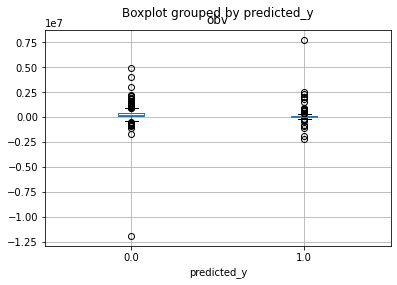

In [ ]:
test_df.boxplot(column='obv',by='predicted_y', fontsize = 10)
print('Predicted y = 1:')
print(test_df[test_df['predicted_y'] == 1]['obv'].describe())
print('Predicted y = 0:')
print(test_df[test_df['predicted_y'] == 0]['obv'].describe())

**OBV (The On Balance Volume)**- this feature can be used to measure the momentum of a stock. It does this by comparing the volume of a stock to its price. If the stock price has increased compared to yesterday, the volume is added to today's closing price. Conversely, if the stock price has decreased compared to yesterday, the volume is subtracted from today's closing price. This measure can be used to identify short-term trends in the stock price, which can be used to inform investment decisions.

analyzing the difference in statistical data:

* the predicted lable 1 stocks have a higher maximum value for the OBV feature than the predicted lable 0 stocks, indicating that the stocks predicted to be lable 1 have higher trading volumes than the stocks predicted to be lable 0.
A higher trading volume means that a greater number of shares are being traded in a given period of time. This indicates that more investors are interested in the stock.


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Predicted y = 1:
count    146.000000
mean       0.071250
std        0.604492
min       -0.999758
25%       -0.056806
50%       -0.013065
75%        0.015520
max        6.516129
Name: Price Change, dtype: float64
Predicted y = 0:
count    351.000000
mean       0.076138
std        0.136813
min       -0.912823
25%        0.016262
50%        0.059457
75%        0.124945
max        0.822621
Name: Price Change, dtype: float64


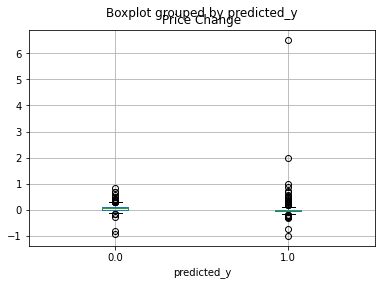

In [ ]:
test_df.boxplot(column='Price Change',by='predicted_y', fontsize = 10)
print('Predicted y = 1:')
print(test_df[test_df['predicted_y'] == 1]['Price Change'].describe())
print('Predicted y = 0:')
print(test_df[test_df['predicted_y'] == 0]['Price Change'].describe())

**Price change** - this feature is the difference between the closing price of a stock today and the closing price of the same stock yesterday. It's a measure of short-term volatility and can be used to measure the overall market sentiment for a particular stock. A positive price change indicates that the stock's price has gone up from yesterday and a negative price change indicates that the stock's price has gone down from yesterday. The price change is a useful indicator for traders and investors looking to make decisions on when to buy or sell a stock.

analyzing the difference in statistical data:

*  it can be concluded that the predicted labled 1 stocks have a higher maximum value for the price change feature than the predicted labled 0 stocks, indicating that the stocks predicted to be lable 1 have higher price appreciation than the stocks predicted to be false. This may indicate that the prices of stocks that got the lable 1 increased in the last months and that they have a greater range of values. 

* the standard deviation of the shares that received the lable 1 is higher than that of the shares that received the lable 0. Meaning, that the shares that received the lable 1 grew at a faster rate and their price went up. it may indicate that the stock or security is more volatile and therefore may be assigned a higher risk level.
